Found 2642 files belonging to 12 classes.
Found 570 files belonging to 12 classes.
Found 574 files belonging to 12 classes.


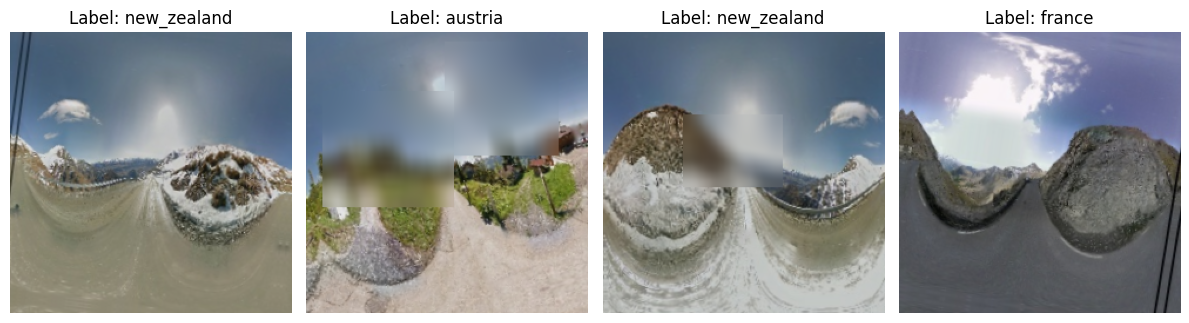

In [24]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import EfficientNetB1, efficientnet
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from sklearn.utils import class_weight
import tensorflow_addons as tfa
import numpy as np
import os

DATA_DIR = "all_images_sets_cropped"
IMG_SIZE = (240, 240)
BATCH_SIZE = 32
EPOCHS = 25
AUTOTUNE = tf.data.AUTOTUNE
SEED = 42

class RandomBlurRegion(tf.keras.layers.Layer):
    def __init__(self, prob=0.25, min_size=60, max_size=120, num_regions=3, **kwargs):
        super().__init__(**kwargs)
        self.prob = prob
        self.min_size = min_size
        self.max_size = max_size
        self.num_regions = num_regions

    def call(self, images, training=False):
        if not training:
            return images

        img_height = tf.shape(images)[1]
        img_width = tf.shape(images)[2]

        def blur_image(image):
            image = tf.identity(image)
            for _ in tf.range(self.num_regions):
                should_blur = tf.less(tf.random.uniform([], 0, 1), self.prob)
                if not should_blur:
                    continue

                box_height = tf.random.uniform([], self.min_size, self.max_size + 1, dtype=tf.int32)
                box_width = tf.random.uniform([], self.min_size, self.max_size + 1, dtype=tf.int32)
                top = tf.random.uniform([], 0, img_height - box_height + 1, dtype=tf.int32)
                left = tf.random.uniform([], 0, img_width - box_width + 1, dtype=tf.int32)

                region = image[top:top+box_height, left:left+box_width, :]
                blurred = tfa.image.gaussian_filter2d(region, filter_shape=(21, 21), sigma=10.0)

                yy, xx = tf.meshgrid(tf.range(top, top + box_height), tf.range(left, left + box_width), indexing='ij')
                indices = tf.stack([yy, xx], axis=-1)
                indices = tf.reshape(indices, (-1, 2))
                updates = tf.reshape(blurred, (-1, 3))
                image = tf.tensor_scatter_nd_update(image, indices, updates)

            return image

        return tf.map_fn(blur_image, images)

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomZoom(0.1),
    layers.RandomRotation(0.05),
    layers.RandomContrast(0.1),
    RandomBlurRegion(prob=0.25, min_size=60, max_size=120, num_regions=3)
])

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(DATA_DIR, "train"),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
    shuffle=True,
    seed=SEED
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(DATA_DIR, "val"),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
    shuffle=True,
    seed=SEED
)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(DATA_DIR, "test"),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
    shuffle=False
)

class_names = train_ds.class_names
num_classes = len(class_names)

# Prefetch datasets
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)
test_ds = test_ds.prefetch(AUTOTUNE)

# ==== Class weights (vóór augmentatie) ====
train_labels = []
for _, labels in train_ds:
    train_labels.extend(np.argmax(labels.numpy(), axis=1))

weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights = dict(enumerate(weights))


base_model = EfficientNetB1(include_top=False, input_shape=IMG_SIZE + (3,), weights='imagenet')
base_model.trainable = False

inputs = tf.keras.Input(shape=IMG_SIZE + (3,))
x = data_augmentation(inputs)  
x = efficientnet.preprocess_input(x)
x = base_model(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
outputs = Dense(num_classes, activation='softmax')(x)

import matplotlib.pyplot as plt

for images, labels in train_ds.take(1):
    images = tf.cast(images, tf.float32)  # blijf in 0–255 bereik
    augmented_images = data_augmentation(images, training=True)
    break


plt.figure(figsize=(12, 4))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    img = tf.clip_by_value(augmented_images[i] / 255.0, 0.0, 1.0).numpy()
    plt.imshow(img)
    label_idx = tf.argmax(labels[i]).numpy()
    plt.title(f"Label: {class_names[label_idx]}")
    plt.axis("off")
plt.tight_layout()
plt.show()



In [25]:
model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3)
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    class_weight=class_weights,
    callbacks=callbacks
)

model.save("saved_models/AAB_ASS2_b1_augmented_blurred.h5")

Epoch 1/25
83/83 [==============================] - 211s 2s/step - loss: 2.0075 - accuracy: 0.3160 - val_loss: 1.6447 - val_accuracy: 0.4930 - lr: 0.0010
Epoch 2/25
83/83 [==============================] - 262s 3s/step - loss: 1.4894 - accuracy: 0.5004 - val_loss: 1.3898 - val_accuracy: 0.5684 - lr: 0.0010
Epoch 3/25
83/83 [==============================] - 261s 3s/step - loss: 1.3025 - accuracy: 0.5530 - val_loss: 1.2737 - val_accuracy: 0.5877 - lr: 0.0010
Epoch 4/25
83/83 [==============================] - 214s 3s/step - loss: 1.2079 - accuracy: 0.5780 - val_loss: 1.2100 - val_accuracy: 0.6035 - lr: 0.0010
Epoch 5/25
83/83 [==============================] - 186s 2s/step - loss: 1.1274 - accuracy: 0.6048 - val_loss: 1.1350 - val_accuracy: 0.6193 - lr: 0.0010
Epoch 6/25
83/83 [==============================] - 180s 2s/step - loss: 1.0887 - accuracy: 0.6196 - val_loss: 1.0934 - val_accuracy: 0.6281 - lr: 0.0010
Epoch 7/25
83/83 [==============================] - 150s 2s/step - loss: 1.0

C:\Users\guuss\anaconda3\envs\tf_env\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


18/18 [==============================] - 23s 1s/step - loss: 0.9362 - accuracy: 0.6969

✅ Test accuracy: 0.6969
Test loss: 0.9362
1/1 [==============================] - 4s 4s/step


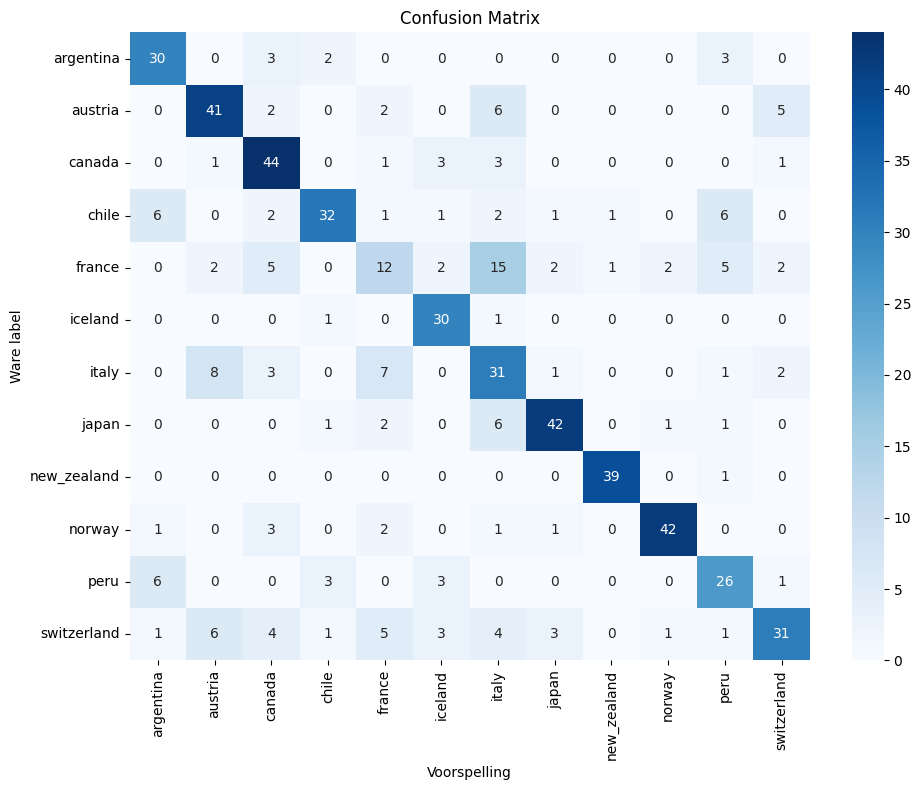


📊 Classification report:
              precision    recall  f1-score   support

   argentina       0.68      0.79      0.73        38
     austria       0.71      0.73      0.72        56
      canada       0.67      0.83      0.74        53
       chile       0.80      0.62      0.70        52
      france       0.38      0.25      0.30        48
     iceland       0.71      0.94      0.81        32
       italy       0.45      0.58      0.51        53
       japan       0.84      0.79      0.82        53
 new_zealand       0.95      0.97      0.96        40
      norway       0.91      0.84      0.88        50
        peru       0.59      0.67      0.63        39
 switzerland       0.74      0.52      0.61        60

    accuracy                           0.70       574
   macro avg       0.70      0.71      0.70       574
weighted avg       0.70      0.70      0.69       574



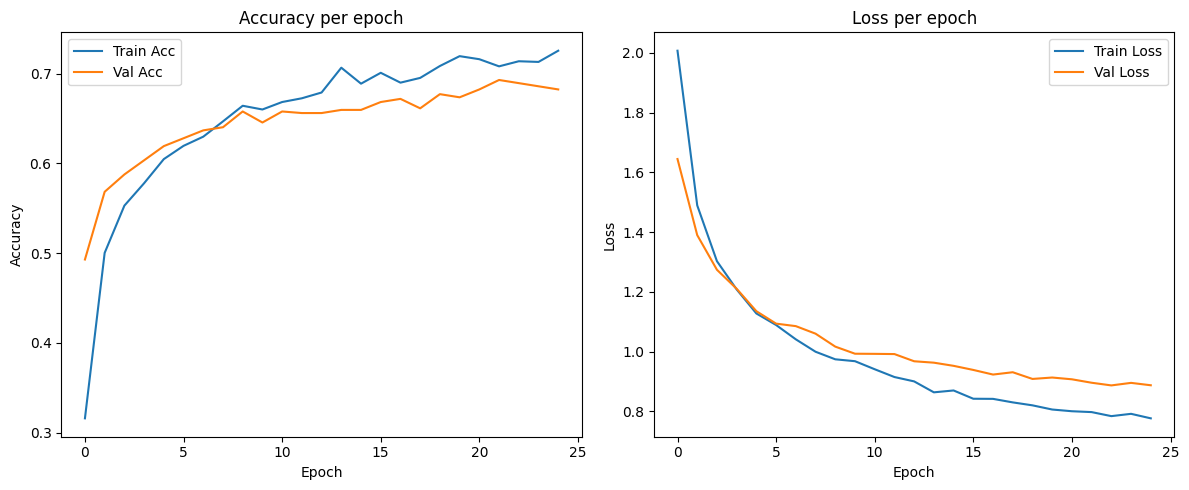

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

loss, accuracy = model.evaluate(test_ds)
print(f"\n✅ Test accuracy: {accuracy:.4f}")
print(f"Test loss: {loss:.4f}")

y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(np.argmax(labels.numpy(), axis=1))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Voorspelling")
plt.ylabel("Ware label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

print("\n📊 Classification report:")
print(classification_report(y_true, y_pred, target_names=class_names))
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.title("Accuracy per epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Loss per epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


In [27]:
np.savez("training_history_efficientnetb1_blurred.npz",
         accuracy=history.history['accuracy'],
         val_accuracy=history.history['val_accuracy'],
         loss=history.history['loss'],
         val_loss=history.history['val_loss'])

### Finetunen van 30 layers zoals bij black boxes

In [28]:
base_model = model.get_layer("efficientnetb1")  

base_model.trainable = True
fine_tune_at = len(base_model.layers) - 30
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

fine_tune_callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)
]

fine_tune_history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    class_weight=class_weights,
    callbacks=fine_tune_callbacks
)

model.save("saved_models/AAB_ASS2_b1_augmented_blurred_finetuned_last30.h5")

Epoch 1/10
83/83 [==============================] - 199s 2s/step - loss: 0.7352 - accuracy: 0.7366 - val_loss: 0.8855 - val_accuracy: 0.6772 - lr: 1.0000e-05
Epoch 2/10
83/83 [==============================] - 188s 2s/step - loss: 0.7295 - accuracy: 0.7369 - val_loss: 0.8741 - val_accuracy: 0.6842 - lr: 1.0000e-05
Epoch 3/10
83/83 [==============================] - 187s 2s/step - loss: 0.7320 - accuracy: 0.7260 - val_loss: 0.8650 - val_accuracy: 0.6754 - lr: 1.0000e-05
Epoch 4/10
83/83 [==============================] - 184s 2s/step - loss: 0.7106 - accuracy: 0.7358 - val_loss: 0.8578 - val_accuracy: 0.6895 - lr: 1.0000e-05
Epoch 5/10
83/83 [==============================] - 186s 2s/step - loss: 0.7058 - accuracy: 0.7347 - val_loss: 0.8507 - val_accuracy: 0.6842 - lr: 1.0000e-05
Epoch 6/10
83/83 [==============================] - 180s 2s/step - loss: 0.6824 - accuracy: 0.7468 - val_loss: 0.8431 - val_accuracy: 0.6965 - lr: 1.0000e-05
Epoch 7/10
83/83 [==============================] - 

C:\Users\guuss\anaconda3\envs\tf_env\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


18/18 [==============================] - 22s 1s/step - loss: 0.8899 - accuracy: 0.7038

✅ Test accuracy: 0.7038
Test loss: 0.8899
1/1 [==============================] - 3s 3s/step


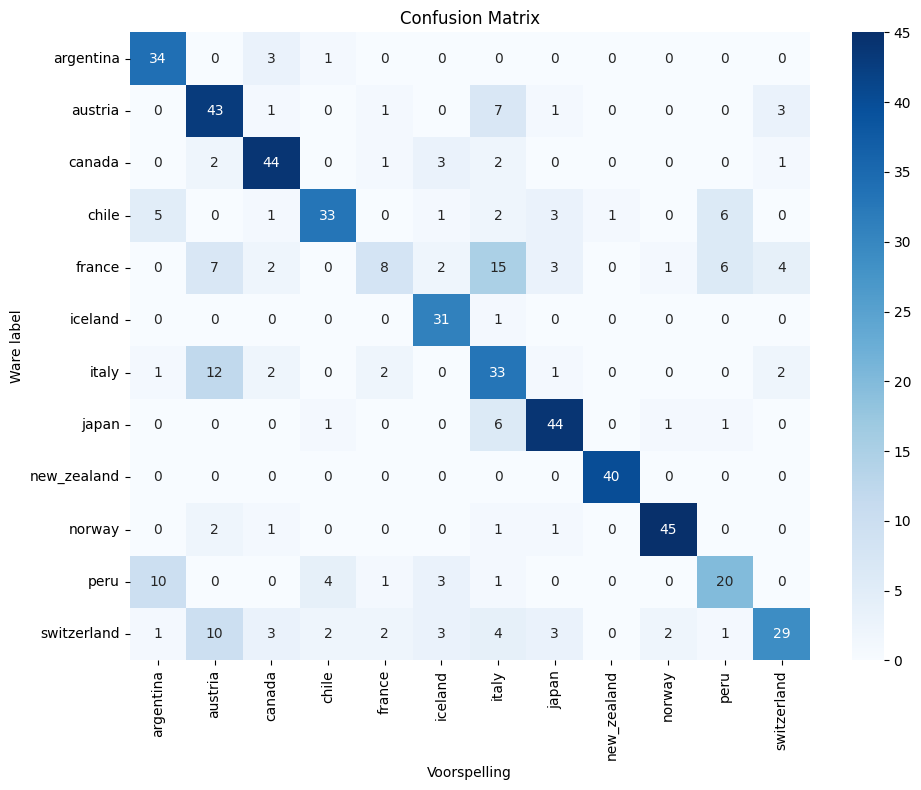


📊 Classification report:
              precision    recall  f1-score   support

   argentina       0.67      0.89      0.76        38
     austria       0.57      0.77      0.65        56
      canada       0.77      0.83      0.80        53
       chile       0.80      0.63      0.71        52
      france       0.53      0.17      0.25        48
     iceland       0.72      0.97      0.83        32
       italy       0.46      0.62      0.53        53
       japan       0.79      0.83      0.81        53
 new_zealand       0.98      1.00      0.99        40
      norway       0.92      0.90      0.91        50
        peru       0.59      0.51      0.55        39
 switzerland       0.74      0.48      0.59        60

    accuracy                           0.70       574
   macro avg       0.71      0.72      0.70       574
weighted avg       0.71      0.70      0.69       574



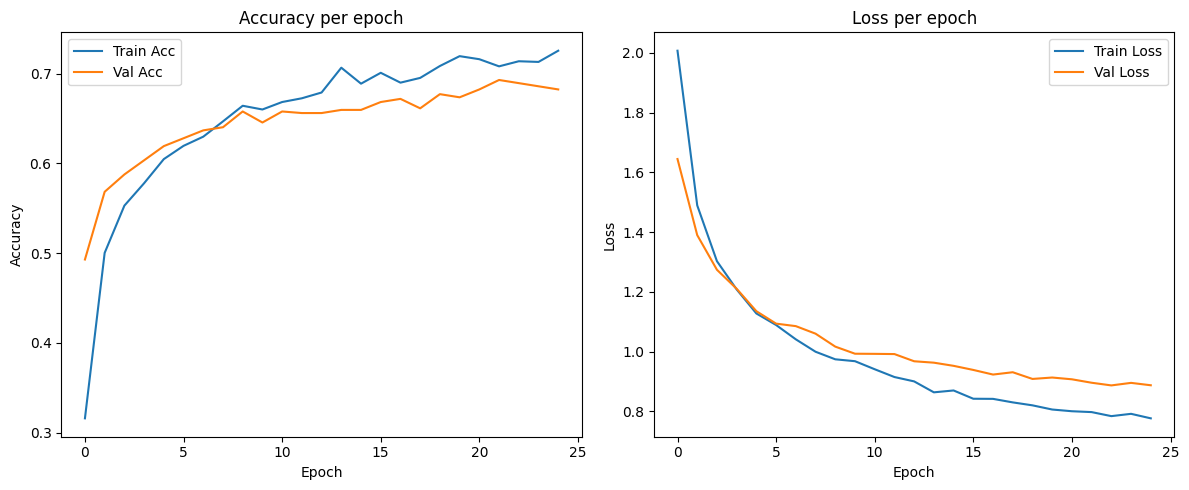

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

loss, accuracy = model.evaluate(test_ds)
print(f"\n✅ Test accuracy: {accuracy:.4f}")
print(f"Test loss: {loss:.4f}")

y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(np.argmax(labels.numpy(), axis=1))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Voorspelling")
plt.ylabel("Ware label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

print("\n📊 Classification report:")
print(classification_report(y_true, y_pred, target_names=class_names))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.title("Accuracy per epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Loss per epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

In [30]:
np.savez("training_history_efficientnetb1_blurred_finetuned.npz",
         accuracy=history.history['accuracy'],
         val_accuracy=history.history['val_accuracy'],
         loss=history.history['loss'],
         val_loss=history.history['val_loss'])

### Fine tunen oon Alpine countries (not used at the end because it did not increase a lot

In [34]:
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np
import tensorflow as tf

model = load_model(
    "saved_models/AAB_ASS2_b1_augmented_blurred_finetuned_last30.h5",
    custom_objects={"RandomBlurRegion": RandomBlurRegion},
    compile=False
)

In [35]:
custom_weights = np.ones(len(class_names))
for label in ['france', 'italy', 'austria', 'switzerland']:
    custom_weights[class_names.index(label)] = 3.0  

class_weights_tensor = tf.constant(custom_weights, dtype=tf.float32)

def weighted_categorical_crossentropy(class_weights_tensor):
    def loss(y_true, y_pred):
        weights = tf.reduce_sum(class_weights_tensor * y_true, axis=-1)
        ce = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
        return ce * weights
    return loss


In [36]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=weighted_categorical_crossentropy(class_weights_tensor),
    metrics=['accuracy']
)

fine_tune_callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)
]

fine_tune_history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=6,
    callbacks=fine_tune_callbacks
)

Epoch 1/6
83/83 [==============================] - 251s 3s/step - loss: 1.4396 - accuracy: 0.7468 - val_loss: 1.7142 - val_accuracy: 0.6842 - lr: 1.0000e-05
Epoch 2/6
83/83 [==============================] - 221s 3s/step - loss: 1.4138 - accuracy: 0.7494 - val_loss: 1.7050 - val_accuracy: 0.6982 - lr: 1.0000e-05
Epoch 3/6
83/83 [==============================] - 218s 3s/step - loss: 1.3832 - accuracy: 0.7566 - val_loss: 1.7230 - val_accuracy: 0.6895 - lr: 1.0000e-05
Epoch 4/6
83/83 [==============================] - 235s 3s/step - loss: 1.4113 - accuracy: 0.7547 - val_loss: 1.6969 - val_accuracy: 0.7000 - lr: 1.0000e-05
Epoch 5/6
83/83 [==============================] - 212s 3s/step - loss: 1.3418 - accuracy: 0.7771 - val_loss: 1.6881 - val_accuracy: 0.7123 - lr: 1.0000e-05
Epoch 6/6
83/83 [==============================] - 216s 3s/step - loss: 1.3221 - accuracy: 0.7668 - val_loss: 1.6725 - val_accuracy: 0.7123 - lr: 1.0000e-05


In [37]:
model.save("saved_models/AAB_ASS2_b1_augmented_blurred_finetuned_lossweighted_confused_focus.h5")

C:\Users\guuss\anaconda3\envs\tf_env\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


18/18 [==============================] - 30s 2s/step - loss: 1.7351 - accuracy: 0.7038

✅ Test Accuracy: 0.7038
1/1 [==============================] - 5s 5s/step


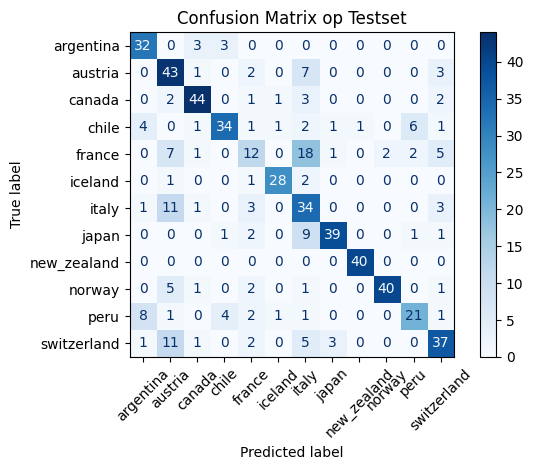


📊 Classification Report:

              precision    recall  f1-score   support

   argentina       0.70      0.84      0.76        38
     austria       0.53      0.77      0.63        56
      canada       0.83      0.83      0.83        53
       chile       0.81      0.65      0.72        52
      france       0.43      0.25      0.32        48
     iceland       0.90      0.88      0.89        32
       italy       0.41      0.64      0.50        53
       japan       0.89      0.74      0.80        53
 new_zealand       0.98      1.00      0.99        40
      norway       0.95      0.80      0.87        50
        peru       0.70      0.54      0.61        39
 switzerland       0.69      0.62      0.65        60

    accuracy                           0.70       574
   macro avg       0.73      0.71      0.71       574
weighted avg       0.72      0.70      0.70       574



In [39]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

def weighted_categorical_crossentropy(class_weights_tensor):
    def loss(y_true, y_pred):
        weights = tf.reduce_sum(class_weights_tensor * y_true, axis=-1)
        ce = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
        return ce * weights
    return loss

custom_weights = np.ones(len(class_names))
for label in ['france', 'italy', 'austria', 'switzerland']:
    custom_weights[class_names.index(label)] = 3.0

class_weights_tensor = tf.constant(custom_weights, dtype=tf.float32)
custom_loss = weighted_categorical_crossentropy(class_weights_tensor)

model = load_model(
    "saved_models/AAB_ASS2_b1_augmented_blurred_finetuned_lossweighted_confused_focus.h5",
    custom_objects={
        "RandomBlurRegion": RandomBlurRegion,
        "loss": custom_loss
    }
)

test_loss, test_acc = model.evaluate(test_ds)
print(f"\n✅ Test Accuracy: {test_acc:.4f}")

y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix op Testset")
plt.tight_layout()
plt.show()

print("\n📊 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))
